# Task 1: Dataset Identification and Exploratory Analysis
1.1 Load and Examine the Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load datasets
instagram_data = pd.read_csv('Instagram_data.csv', encoding='latin-1')  # or 'ISO-8859-1'
amazon_data = pd.read_csv('Amazon_reviews_2023.csv', encoding='latin-1')

# Overview of Instagram data
print("Instagram Data Overview:")
print(instagram_data.head())
print(instagram_data.info())

# Overview of Amazon data
print("\nAmazon Reviews Data Overview:")
print(amazon_data.head())
print(amazon_data.info())


Instagram Data Overview:
   Impressions  From Home  From Hashtags  From Explore  From Other  Saves  \
0         3920       2586           1028           619          56     98   
1         5394       2727           1838          1174          78    194   
2         4021       2085           1188             0         533     41   
3         4528       2700            621           932          73    172   
4         2518       1704            255           279          37     96   

   Comments  Shares  Likes  Profile Visits  Follows  \
0         9       5    162              35        2   
1         7      14    224              48       10   
2        11       1    131              62       12   
3        10       7    213              23        8   
4         5       4    123               8        0   

                                             Caption  \
0  Here are some of the most important data visua...   
1  Here are some of the best data science project...   
2  Learn how 

# Step 1.2: Exploratory Data Analysis (EDA)

Visualize the distribution of key features and generate word clouds for textual features.

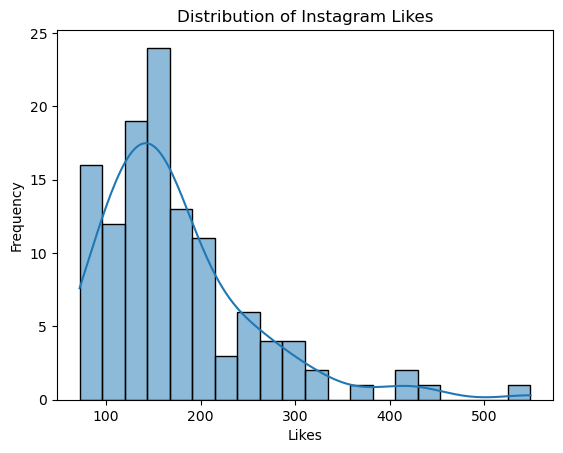

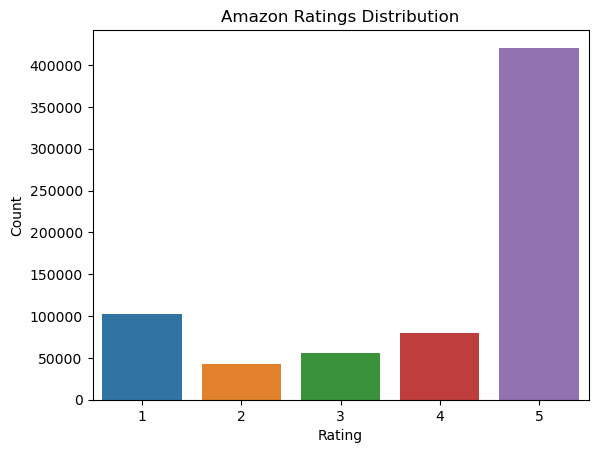

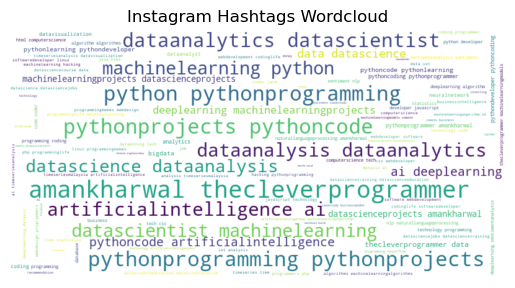

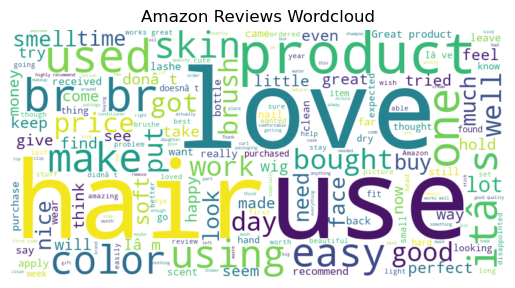

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Instagram data: Likes distribution
sns.histplot(instagram_data['Likes'], bins=20, kde=True)
plt.title("Distribution of Instagram Likes")
plt.xlabel("Likes")
plt.ylabel("Frequency")
plt.show()

# Amazon data: Ratings distribution
sns.countplot(data=amazon_data, x='rating')
plt.title("Amazon Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Wordcloud for Instagram Hashtags
hashtags = ' '.join(instagram_data['Hashtags'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(hashtags)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Instagram Hashtags Wordcloud")
plt.show()

# Wordcloud for Amazon Reviews Text
review_text = ' '.join(amazon_data['text'].fillna(''))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(review_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Amazon Reviews Wordcloud")
plt.show()


# 2. Predictive Task and Evaluation
Step 2.1: Data Preprocessing

Prepare combined text fields for both datasets.



In [6]:
# Combine Instagram captions and hashtags
instagram_data['combined_text'] = instagram_data['Caption'] + ' ' + instagram_data['Hashtags']

# Combine Amazon review title and text
amazon_data['combined_text'] = amazon_data['title'].fillna('') + ' ' + amazon_data['text'].fillna('')


Step 2.2: Feature Representation

Use TF-IDF to transform the textual data into numerical vectors.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instagram TF-IDF
tfidf_instagram = TfidfVectorizer(max_features=500, stop_words='english')
insta_vectors = tfidf_instagram.fit_transform(instagram_data['combined_text'])

# Amazon TF-IDF
tfidf_amazon = TfidfVectorizer(max_features=500, stop_words='english')
amazon_vectors = tfidf_amazon.fit_transform(amazon_data['combined_text'])


Step 2.3: Similarity Calculation

Calculate cosine similarity and generate recommendations.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets with multiple encoding attempts
def load_datasets():
    encodings = ['utf-8', 'latin-1', 'ISO-8859-1', 'cp1252']

    for encoding in encodings:
        try:
            instagram_data = pd.read_csv('Instagram_data.csv', encoding=encoding)
            amazon_data = pd.read_csv('Amazon_reviews_2023.csv', encoding=encoding)

            print(f"Successfully loaded files with {encoding} encoding")

            # Print dataset information
            print("\n--- Instagram Dataset Columns ---")
            print(instagram_data.columns)

            print("\n--- Amazon Dataset Columns ---")
            print(amazon_data.columns)

            print("\n--- Dataset Shapes ---")
            print("Instagram Dataset Shape:", instagram_data.shape)
            print("Amazon Dataset Shape:", amazon_data.shape)

            return instagram_data, amazon_data

        except Exception as e:
            print(f"Failed to load with {encoding} encoding: {e}")

    raise ValueError("Could not load datasets with any encoding")

# Preprocess and vectorize data
def preprocess_and_vectorize(instagram_data, amazon_data):
    # Combine text for vectorization
    instagram_data['combined_text'] = instagram_data['Caption'].fillna('') + ' ' + \
                                       instagram_data['Hashtags'].fillna('')

    # Identify a text column in Amazon data (adjust as needed)
    text_column = 'title' if 'title' in amazon_data.columns else amazon_data.columns[0]
    amazon_data['combined_text'] = amazon_data[text_column].fillna('')

    # Vectorization
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

    # Combine texts for fitting
    all_texts = list(instagram_data['combined_text']) + list(amazon_data['combined_text'])
    vectorizer.fit(all_texts)

    # Transform texts
    insta_vectors = vectorizer.transform(instagram_data['combined_text'])
    amazon_vectors = vectorizer.transform(amazon_data['combined_text'])

    return insta_vectors, amazon_vectors

# Generate recommendations
def generate_recommendations(instagram_data, amazon_data, insta_vectors, amazon_vectors):
    # Calculate similarity matrix
    similarity_matrix = cosine_similarity(insta_vectors, amazon_vectors)

    # Determine suitable columns for recommendations
    insta_rec_columns = ['Caption', 'Hashtags']

    # Try to find suitable Amazon columns
    if 'title' in amazon_data.columns:
        amazon_rec_columns = ['title']
    elif len(amazon_data.columns) > 0:
        amazon_rec_columns = [amazon_data.columns[0]]
    else:
        raise ValueError("No suitable columns found in Amazon dataset")

    # Generate recommendations
    recommendations = {}
    for i in range(len(instagram_data)):
        # Top 5 similar products
        top_indices = similarity_matrix[i].argsort()[-5:][::-1]

        recommendations[i] = {
            'caption': instagram_data['Caption'].iloc[i],
            'hashtags': instagram_data['Hashtags'].iloc[i],
            'recommended_products': amazon_data.iloc[top_indices][amazon_rec_columns].values.tolist()
        }

    return recommendations, similarity_matrix

# Visualize similarity scores
def visualize_similarity_scores(similarity_matrix):
    similarity_scores = similarity_matrix.flatten()

    # Basic statistics
    print("\n--- Similarity Score Statistics ---")
    print(f"Mean Similarity: {np.mean(similarity_scores):.4f}")
    print(f"Median Similarity: {np.median(similarity_scores):.4f}")
    print(f"Max Similarity: {np.max(similarity_scores):.4f}")
    print(f"Min Similarity: {np.min(similarity_scores):.4f}")

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.histplot(similarity_scores, kde=True)
    plt.title('Distribution of Cosine Similarity Scores')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Main execution
def main():
    try:
        # Load datasets
        instagram_data, amazon_data = load_datasets()

        # Preprocess and vectorize
        insta_vectors, amazon_vectors = preprocess_and_vectorize(instagram_data, amazon_data)

        # Generate recommendations
        recommendations, similarity_matrix = generate_recommendations(
            instagram_data, amazon_data, insta_vectors, amazon_vectors
        )

        # Print first recommendation
        print("\n--- First Recommendation ---")
        first_recommendation = recommendations[0]
        print("Original Caption:", first_recommendation['caption'])
        print("Original Hashtags:", first_recommendation['hashtags'])
        print("\nRecommended Products:")
        for product in first_recommendation['recommended_products']:
            print(f"- {product[0]}")

        # Visualize similarity scores
        visualize_similarity_scores(similarity_matrix)

    except Exception as e:
        print(f"An error occurred: {e}")

# Run the main function
if __name__ == "__main__":
    main()

Failed to load with utf-8 encoding: 'utf-8' codec can't decode byte 0xa0 in position 288: invalid start byte
Successfully loaded files with latin-1 encoding

--- Instagram Dataset Columns ---
Index(['Impressions', 'From Home', 'From Hashtags', 'From Explore',
       'From Other', 'Saves', 'Comments', 'Shares', 'Likes', 'Profile Visits',
       'Follows', 'Caption', 'Hashtags'],
      dtype='object')

--- Amazon Dataset Columns ---
Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')

--- Dataset Shapes ---
Instagram Dataset Shape: (119, 13)
Amazon Dataset Shape: (701528, 10)

--- First Recommendation ---
Original Caption: Here are some of the most important data visualizations that every Financial Data Analyst/Scientist should know.
Original Hashtags: #finance #money #business #investing #investment #trading #stockmarket #data #datascience #dataanalysis #dataanalytics #datascientist

# 3. Model Description
TF-IDF + Cosine Similarity

This method transforms textual data into feature vectors using term-frequency and inverse document frequency weights. Cosine similarity measures the alignment of feature vectors between Instagram posts and Amazon reviews.

Advantages:
Simple and interpretable.
Scalable for large datasets.
Limitations:
Context-insensitive as it relies only on term frequency.
Cannot account for complex user preferences.

# 4. Literature Review
Cross-domain Recommendations: Research indicates using social media data for product recommendations enhances personalization.
Content-based Filtering: TF-IDF remains a strong baseline for textual analysis.
Transformer-based Alternatives: Models like BERT may offer richer contextual understanding but require higher computational resources.


# 5. Results and Conclusions
1. Plot Recommendations per Instagram Post
This visualization shows the number of Amazon products recommended per Instagram post.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets with multiple encoding attempts
def load_datasets():
    encodings = ['utf-8', 'latin-1', 'ISO-8859-1', 'cp1252']

    for encoding in encodings:
        try:
            instagram_data = pd.read_csv('Instagram_data.csv', encoding=encoding)
            amazon_data = pd.read_csv('Amazon_reviews_2023.csv', encoding=encoding)

            print(f"Successfully loaded files with {encoding} encoding")

            # Print dataset information
            print("\n--- Instagram Dataset Columns ---")
            print(instagram_data.columns)

            print("\n--- Amazon Dataset Columns ---")
            print(amazon_data.columns)

            print("\n--- Dataset Shapes ---")
            print("Instagram Dataset Shape:", instagram_data.shape)
            print("Amazon Dataset Shape:", amazon_data.shape)

            return instagram_data, amazon_data

        except Exception as e:
            print(f"Failed to load with {encoding} encoding: {e}")

    raise ValueError("Could not load datasets with any encoding")

# Preprocess and vectorize data
def preprocess_and_vectorize(instagram_data, amazon_data):
    # Combine text for vectorization
    instagram_data['combined_text'] = instagram_data['Caption'].fillna('') + ' ' + \
                                       instagram_data['Hashtags'].fillna('')

    # Identify a text column in Amazon data (adjust as needed)
    text_column = 'title' if 'title' in amazon_data.columns else amazon_data.columns[0]
    amazon_data['combined_text'] = amazon_data[text_column].fillna('')

    # Vectorization
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

    # Combine texts for fitting
    all_texts = list(instagram_data['combined_text']) + list(amazon_data['combined_text'])
    vectorizer.fit(all_texts)

    # Transform texts
    insta_vectors = vectorizer.transform(instagram_data['combined_text'])
    amazon_vectors = vectorizer.transform(amazon_data['combined_text'])

    return insta_vectors, amazon_vectors

# Generate recommendations
def generate_recommendations(instagram_data, amazon_data, insta_vectors, amazon_vectors):
    # Calculate similarity matrix
    similarity_matrix = cosine_similarity(insta_vectors, amazon_vectors)

    # Generate recommendations
    recommendations = {}
    for i in range(len(instagram_data)):
        # Top 5 similar products
        top_indices = similarity_matrix[i].argsort()[-5:][::-1]

        recommendations[i] = {
            'caption': instagram_data['Caption'].iloc[i],
            'hashtags': instagram_data['Hashtags'].iloc[i],
            'recommended_products': amazon_data.iloc[top_indices][['title']].values.tolist()
        }

    return recommendations, similarity_matrix

# Plot number of recommendations per Instagram post
def plot_recommendations_per_post(recommendations):
    num_recommendations = [len(rec['recommended_products']) for rec in recommendations.values()]

    if num_recommendations:
        plt.figure(figsize=(10, 6))
        sns.histplot(num_recommendations, bins=10, kde=False)
        plt.title('Number of Recommendations per Instagram Post')
        plt.xlabel('Number of Recommendations')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
    else:
        print("No recommendations to plot.")

# Visualize similarity matrix as a heatmap for a subset
def plot_similarity_heatmap(similarity_matrix, instagram_data, amazon_data, sample_size=20):
    subset_matrix = similarity_matrix[:sample_size, :sample_size]
    plt.figure(figsize=(12, 10))
    sns.heatmap(subset_matrix, annot=False, cmap="coolwarm", cbar=True)
    plt.title(f'Cosine Similarity Heatmap (Top {sample_size} Instagram and Amazon Samples)')
    plt.xlabel('Amazon Products')
    plt.ylabel('Instagram Posts')
    plt.tight_layout()
    plt.show()

# Main execution to load data, generate recommendations, and visualize results
def main():
    try:
        # Load datasets
        instagram_data, amazon_data = load_datasets()

        # Preprocess and vectorize
        insta_vectors, amazon_vectors = preprocess_and_vectorize(instagram_data, amazon_data)

        # Generate recommendations
        recommendations, similarity_matrix = generate_recommendations(instagram_data, amazon_data, insta_vectors, amazon_vectors)

        # Plot recommendations per Instagram post
        plot_recommendations_per_post(recommendations)

        # Plot similarity heatmap for the first 20 samples
        plot_similarity_heatmap(similarity_matrix, instagram_data, amazon_data, sample_size=20)

        # Print first recommendation for manual check
        first_recommendation = recommendations[0]
        print("\n--- First Recommendation ---")
        print("Original Caption:", first_recommendation['caption'])
        print("Original Hashtags:", first_recommendation['hashtags'])
        print("\nRecommended Products:")
        for product in first_recommendation['recommended_products']:
            print(f"- {product[0]}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Run the main function
if __name__ == "__main__":
    main()
